In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 11 20:53:48 2024
@author: ferez
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Load and prepare data
df = pd.read_csv('C:/Users/ferez/Desktop/data_1971.csv')  # Adjust path as needed
df['Date'] = pd.to_datetime(df['Date'], format='%Y %b')
df.set_index('Date', inplace=True)

# Impute missing values
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

# Prepare data for Prophet
df_prophet = df_imputed[['GDP Growth_QoQ']].reset_index()
df_prophet.columns = ['ds', 'y']

# Initialize Prophet model with tuned parameters
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',  # Changed to multiplicative
    changepoint_prior_scale=0.1,        # Increased flexibility
    seasonality_prior_scale=10,         # Stronger seasonality
    changepoint_range=0.9,              # Allow changepoints until 90% of the data
    interval_width=0.95                 # 95% confidence intervals
)

# Add monthly seasonality explicitly
model.add_seasonality(
    name='monthly',
    period=12,        # Monthly seasonality period (months)
    fourier_order=5
)

# Add quarterly seasonality
model.add_seasonality(
    name='quarterly',
    period=3 * 12,    # Quarterly period in months
    fourier_order=3
)

# Fit the model
start_time = time.time()
model.fit(df_prophet)
end_time = time.time()
print(f"Model fitting completed in {end_time - start_time:.2f} seconds")

# Perform cross-validation with monthly intervals (converted to days)
df_cv = cross_validation(
    model,
    initial='730 days',   # 2 years as the initial training period
    period='180 days',    # Cross-validation period every 6 months
    horizon='730 days',   # Forecast horizon of 2 years
    parallel="processes"
)

# Calculate and display metrics
df_metrics = performance_metrics(df_cv)

# Print the performance metrics for confirmation
print("\nPerformance Metrics:")
print(df_metrics)

# Save the performance metrics to an Excel file
df_metrics.to_excel('performance_metrics.xlsx', index=False)

# Make future predictions for the next 355 months (approximately 29 years and 7 months)
future = model.make_future_dataframe(periods=355, freq='M')

# Generate forecast
forecast = model.predict(future)

# Filter out only the forecasted values after the last date in the dataset
last_date = df.index[-1]  # Get the last date from the original dataset
forecast_future = forecast[forecast['ds'] > last_date]  # Filter forecasted data after the last date

# Save only the forecasted values to an Excel file
forecast_future_results = forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'yearly', 'monthly', 'quarterly']]

# Save to Excel
forecast_future_results.to_excel('Aforecasted_GDP.xlsx', index=False)

# Print the saved forecast for confirmation
print(forecast_future_results.head())


13:31:39 - cmdstanpy - INFO - Chain [1] start processing
13:31:39 - cmdstanpy - INFO - Chain [1] done processing


Model fitting completed in 0.26 seconds

Performance Metrics:
     horizon        mse      rmse       mae     mdape     smape  coverage
0    74 days  20.440440  4.521110  2.134872  0.704913  1.014904  0.806818
1    75 days  21.597519  4.647313  2.212712  0.704913  1.021863  0.801653
2    76 days  22.232813  4.715168  2.264053  0.709671  1.031952  0.797521
3    77 days  24.497905  4.949536  2.357815  0.719711  1.044224  0.793388
4    78 days  24.540427  4.953829  2.365195  0.719711  1.046223  0.789256
..       ...        ...       ...       ...       ...       ...       ...
652 726 days  38.837903  6.232006  2.854277  0.916935  1.211722  0.743802
653 727 days  38.845563  6.232621  2.854665  0.931751  1.214271  0.739669
654 728 days  38.663085  6.217965  2.836237  0.931751  1.218032  0.744628
655 729 days  38.596562  6.212613  2.830025  0.935485  1.220989  0.743802
656 730 days  38.319699  6.190291  2.807187  0.935485  1.218343  0.746556

[657 rows x 7 columns]
            ds      yhat  

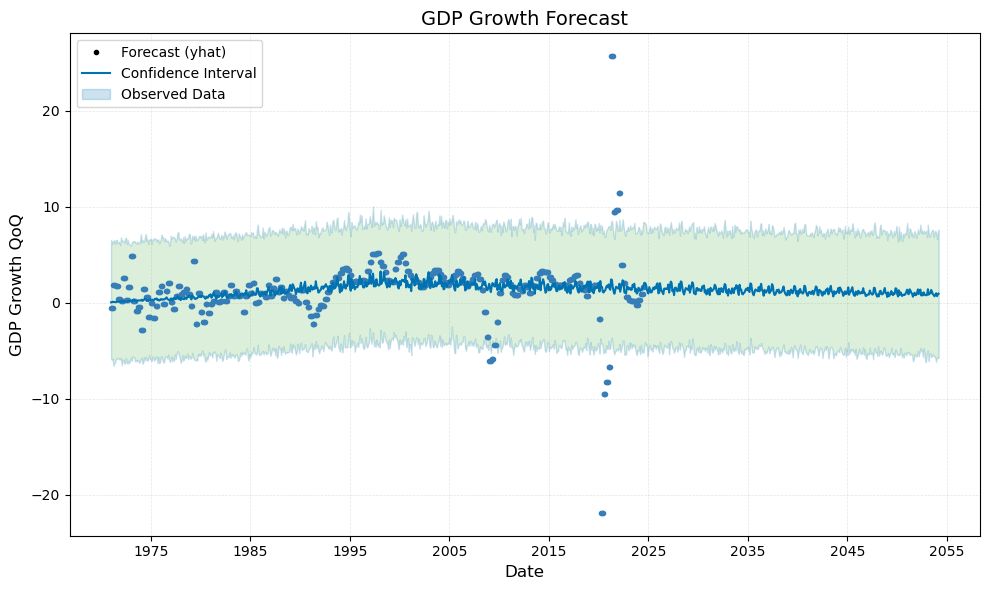

In [5]:
# Plot the forecast with color-blind-friendly colors and a legend
fig_forecast = model.plot(forecast)

# Customize the plot for better clarity
ax = fig_forecast.gca()
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')  # Add gridlines

# Add a legend for clarity
ax.legend(
    ['Forecast (yhat)', 'Confidence Interval', 'Observed Data'],
    loc='upper left', 
    fontsize=10
)

# Set color-blind-friendly palette
colors = ['#377eb8', '#4daf4a', '#e41a1c']  # Blue, green, red
ax.get_lines()[0].set_color(colors[0])  # Main forecast line
ax.collections[0].set_facecolor(colors[1])  # Confidence interval shading

# Add labels and title
plt.title("GDP Growth Forecast", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("GDP Growth QoQ", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
# Example for Unemployment rate

# Prepare data for Prophet
df_prophet_unemployment = df_imputed[['Unemployment rate']].reset_index()
df_prophet_unemployment.columns = ['ds', 'y']

# Initialize Prophet model
model_unemployment = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10,
    changepoint_range=0.9,
    interval_width=0.95
)

# Add monthly seasonality explicitly
model_unemployment.add_seasonality(
    name='monthly',
    period=12,  # Monthly period
    fourier_order=5
)

# Add quarterly seasonality
model_unemployment.add_seasonality(
    name='quarterly',
    period=3 * 12,  # Quarterly period
    fourier_order=3
)

# Fit the model
start_time = time.time()
model_unemployment.fit(df_prophet_unemployment)
end_time = time.time()
print(f"Unemployment rate model fitting completed in {end_time - start_time:.2f} seconds")

# Cross-validation and performance metrics
df_cv_unemployment = cross_validation(
    model_unemployment,
    initial='730 days',
    period='180 days',
    horizon='730 days',
    parallel="processes"
)

df_metrics_unemployment = performance_metrics(df_cv_unemployment)
print("\nUnemployment rate Performance Metrics:")
print(df_metrics_unemployment)

# Save performance metrics for Unemployment rate
df_metrics_unemployment.to_excel('unemployment_rate_performance_metrics.xlsx', index=False)

# Make future predictions for the next 355 months
future_unemployment = model_unemployment.make_future_dataframe(periods=355, freq='M')
forecast_unemployment = model_unemployment.predict(future_unemployment)

# Filter forecasted values after the last date
forecast_future_unemployment = forecast_unemployment[forecast_unemployment['ds'] > df.index[-1]]
forecast_future_results_unemployment = forecast_future_unemployment[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'yearly', 'monthly', 'quarterly']]

# Save the forecast results to Excel
forecast_future_results_unemployment.to_excel('Bforecasted_unemployment_rate.xlsx', index=False)

print(forecast_future_results_unemployment.head())


13:35:31 - cmdstanpy - INFO - Chain [1] start processing
13:35:31 - cmdstanpy - INFO - Chain [1] done processing


Unemployment rate model fitting completed in 0.25 seconds

Unemployment rate Performance Metrics:
     horizon       mse      rmse       mae      mape     mdape     smape  \
0    74 days  0.508136  0.712837  0.482649  0.080912  0.054293  0.081651   
1    75 days  0.566738  0.752820  0.497996  0.085670  0.054293  0.085000   
2    76 days  0.577102  0.759672  0.503383  0.086634  0.055005  0.085781   
3    77 days  0.584825  0.764738  0.509430  0.087603  0.055005  0.086905   
4    78 days  0.584450  0.764493  0.509509  0.087672  0.055005  0.087010   
..       ...       ...       ...       ...       ...       ...       ...   
652 726 days  6.907157  2.628147  1.845605  0.274624  0.189118  0.271498   
653 727 days  6.899945  2.626775  1.843535  0.273724  0.189118  0.270777   
654 728 days  6.882022  2.623361  1.838569  0.272762  0.185244  0.269541   
655 729 days  6.877346  2.622469  1.838159  0.272918  0.185244  0.269496   
656 730 days  6.874065  2.621844  1.842873  0.274243  0.186532  0.

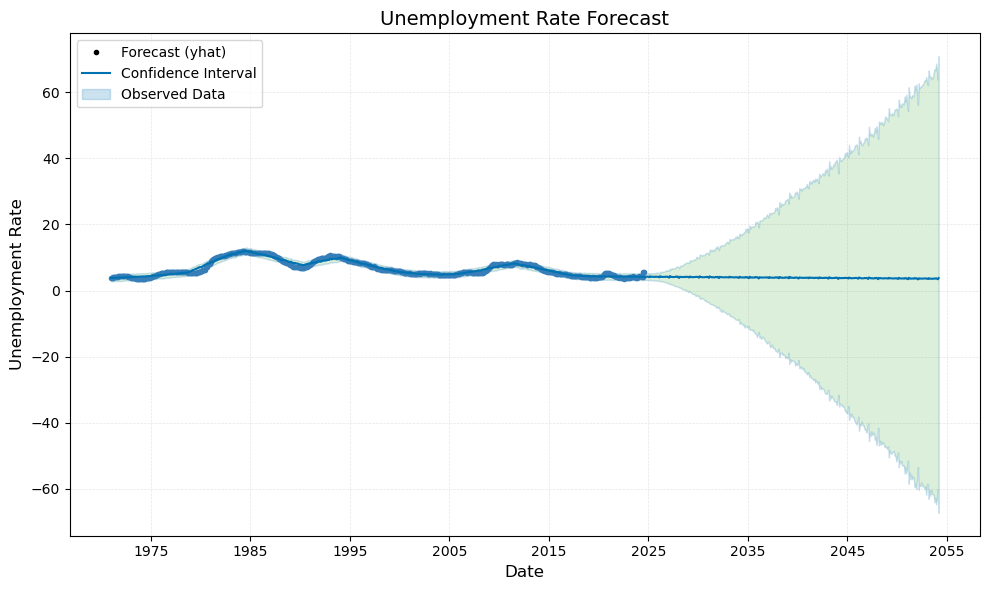

In [11]:
# Plot the unemployment rate forecast with color-blind-friendly colors and a legend
fig_forecast_unemployment = model_unemployment.plot(forecast_unemployment)

# Customize the plot for better clarity
ax = fig_forecast_unemployment.gca()
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')  # Add gridlines

# Add a legend for clarity
ax.legend(
    ['Forecast (yhat)', 'Confidence Interval', 'Observed Data'],
    loc='upper left', 
    fontsize=10
)

# Set color-blind-friendly palette
colors = ['#377eb8', '#4daf4a', '#e41a1c']  # Blue, green, red
ax.get_lines()[0].set_color(colors[0])  # Main forecast line
ax.collections[0].set_facecolor(colors[1])  # Confidence interval shading

# Add labels and title
plt.title("Unemployment Rate Forecast", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Unemployment Rate", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
